# EDA (Topic 1: Computer Vision)

## Overview

### Project Overview

 This project aims to leverage data science techniques to aid emergency response efforts in disaster situations. The goal is to provide quick and accurate information about affected areas, enhancing the effectiveness of the response.

### Goals

The project has three main objectives:

 - To gain experience working with image data, specifically through the use of common feature extraction techniques such as Sobel edge filtering.
 - To handle real-world data complexities, including class imbalance, low signal-to-noise ratio, and high-dimensional data.
 - To design effective preprocessing and featurization pipelines for tackling challenging machine learning tasks.

### Mission

 The mission of this project is to expedite the process of annotating high-resolution satellite images, which are crucial for disaster response. The challenge is to develop a computer vision approach that can automatically assign labels to these images.

### Dataset Description

 The dataset comprises satellite images of buildings post various natural disasters. The buildings are labeled based on the extent of damage sustained, with a scale ranging from 0 (no damage) to 3 (destroyed).

### Tasks

**Disaster Type Classification**
 -  The goal is to build a classifier that can automatically categorize images based on the type of disaster scenario, such as flooding or fire.
   
**Damage Level Classification**
 - The objective is to create a classifier that can automatically determine the level of building damage following a disaster, specifically for hurricanes.



## Group Resources and Documentation

[Project Decription and Requirements](https://ds100.org/sp24/gradproject/)

[Checkpoint 1 Peer Review](https://docs.google.com/document/d/1OsxAc2tLlMfjUKo6kqLkjSFyGHAkNw0dYwyCxPJRM0Y/edit?usp=sharing)

[EDA Report](https://docs.google.com/document/d/1uGEexKdfgWnqgpCZdw4mDDLdXdmsvOgFUIYb103U8fk/edit?usp=sharing)

[EDA Q&A](https://docs.google.com/document/d/1FoMKI6U4TKebRYRNB5MQRUHUG6Q2LmopVlLTjIEYu0w/edit?usp=sharing)

[Source](https://github.com/fractalclockwork/Data200/tree/main)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

import pandas as pd
import seaborn as sns

In [2]:
# For Colab we define a path for local libraries and files 
# this sort defeats the reasoning behind using a JSON config file,
# think about a better way to do this, oh well
COLAB = False

# mount Colab drive and set library path
if COLAB: 
  import sys
  from google.colab import drive
  drive.mount('/content/drive')   
  path = '/content/drive/My Drive/Colab Notebooks/grad_project'
  #data_dir = f'{path}/data/sp24_grad_project_data/satellite-image-data'
  sys.path.insert(0, path) # for colab to see local libraries
else:
  path = '.'
  #data_dir = f'{path}/../Data/sp24_grad_project_data/satellite-image-data'

figure_path = f'{path}/../Figures'

## Loading the data
To get started let's first load in the data! We will make use of the helper functions provided in `data_utils.py`

In [3]:
from data_utils import get_images, get_labels

The following is the list of disasters in our dataset.

In [4]:
disaster_list = ["hurricane-matthew", "socal-fire", "midwest-flooding"]
test_disaster_list = ["hurricane-matthew", "flooding-fire"]

We will load each disaster train dataset into a dictionary. Recall that each disaster consists of images and labels (0 - 3) of the damage level.

In [5]:
data = {}
split = "train"

# this is not a useful abstraction atm
with open(f'{path}/config.json') as config_file:
    config = json.load(config_file)
    if COLAB:
      data_dir = config['colab_data_dir']
    else:
      data_dir = config['data_dir']

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}
    print(f"\tLoaded {len(labels)} records.")

Loading train images and labels for hurricane-matthew dataset...
	Loaded 11151 records.
Loading train images and labels for socal-fire dataset...
	Loaded 8380 records.
Loading train images and labels for midwest-flooding dataset...
	Loaded 7004 records.


In [6]:
import os 
from data_utils import load_images

split = 'test'
test_data = {}
for disaster in test_disaster_list:
    print(f"Loading {split} images for {disaster} test dataset...")
    images_path = os.path.join(data_dir,  f"test_images_{disaster}.npz")
    
    images = load_images(images_path)
    test_data[disaster] = images
    print(f"\tLoaded {len(images)}  records.")

Loading test images for hurricane-matthew test dataset...
	Loaded 2788  records.
Loading test images for flooding-fire test dataset...
	Loaded 3847  records.


In [7]:
!tree {data_dir}

../Data/sp24_grad_project_data/satellite-image-data
├── hurricane-matthew
│   ├── train_images.npz
│   └── train_labels.npy
├── midwest-flooding
│   ├── train_images.npz
│   └── train_labels.npy
├── socal-fire
│   ├── train_images.npz
│   └── train_labels.npy
├── test_images_flooding-fire.npz
└── test_images_hurricane-matthew.npz

3 directories, 8 files


**Observations**

We can see that the files for this dataset have already been split and use the path for disaster type, a file prefix to identify the split(test/train), and a file suffix to identify datatype(image/label).  Let's also consider how we might develop a Class for our EDA.

**Create a dataframe**

Let's create a dataframe with all our data so that we can explore it more easily.  For the sake of clarity and conciseness we'll create a library for our EDA utilities.

In [8]:
# Our library is underdevelopment, thus we reload as we add features.
import eda_utils
from importlib import reload
reload(eda_utils)

df = eda_utils.data2df(disaster_list, data)
assert (df.shape[0] == 26535), 'Invalid dataframe length!'
display(df.describe())

,idx,label,height,width,image_size
count,26535.000000,26535.000000,26535.000000,26535.000000,26535.000000
mean,4590.139099,0.654833,78.507933,80.090183,8169.871867
std,2837.802075,1.000181,49.831279,52.705180,12364.717747
min,0.000000,0.000000,3.000000,3.000000,84.000000
25%,2211.000000,0.000000,43.000000,44.000000,1936.000000
50%,4422.000000,0.000000,66.000000,66.000000,4340.000000
75%,6633.000000,1.000000,104.000000,104.000000,10240.000000
max,11150.000000,3.000000,716.000000,890.000000,410464.000000


In [9]:
df[['avg_color','label']]

,avg_color,label
0,"[75.7022792022792, 105.27578347578347, 101.084...",3
1,"[88.45159914712154, 119.42288557213931, 110.24...",0
2,"[111.97156084656085, 122.16071428571429, 119.0...",1
3,"[96.97969722693831, 128.50396151669497, 127.72...",0
4,"[87.17985125084516, 108.7789046653144, 96.3113...",2
...,...,...
26530,"[90.0832342449465, 117.02497027348394, 109.146...",0
26531,"[95.70530626780626, 125.3482905982906, 122.0]",0
26532,"[64.78615552325581, 90.17532703488372, 77.7979...",0
26533,"[47.41594827586207, 76.15110837438424, 59.3152...",0


In [10]:
type = ['fire', 'flood', 'hurricane']

for t in type:
    print(t,':')
    display(df[df.disaster_type == t].describe().T[['count', 'min','max']])

print('tolal',':')
display(df.describe().T[['count', 'min','max']])

fire :


,count,min,max
idx,8380.0,0.0,8379.0
label,8380.0,0.0,3.0
height,8380.0,4.0,509.0
width,8380.0,3.0,890.0
image_size,8380.0,98.0,289250.0


flood :


,count,min,max
idx,7004.0,0.0,7003.0
label,7004.0,0.0,3.0
height,7004.0,3.0,716.0
width,7004.0,6.0,863.0
image_size,7004.0,126.0,410464.0


hurricane :


,count,min,max
idx,11151.0,0.0,11150.0
label,11151.0,0.0,3.0
height,11151.0,3.0,354.0
width,11151.0,4.0,396.0
image_size,11151.0,84.0,110484.0


tolal :


,count,min,max
idx,26535.0,0.0,11150.0
label,26535.0,0.0,3.0
height,26535.0,3.0,716.0
width,26535.0,3.0,890.0
image_size,26535.0,84.0,410464.0


## Label Distribution

Let's explore our labels to understand their distribution.

In [11]:
!ls {figure_path}

eda_image_color_by_level.png		      eda_image_size_kde_bylevel.png
eda_image_sample_each_type_label.png	      eda_label_ratios_excluded.png
eda_image_size_box.png			      eda_label_ratios.png
eda_image_size_hist_bylevel_dropnodamage.png  eda_label_totals.png
eda_image_size_hist_bylevel.png		      eda_label_totals_sidebyside.png
eda_image_size_hist.png			      README.md


label,0,1,2,3
disaster_type,,,,
fire,7204,69,43,1064
flood,6734,114,97,59
hurricane,2631,5236,1544,1740


label             0     1     2     3
disaster_type                        
fire           7204    69    43  1064
flood          6734   114    97    59
hurricane      2631  5236  1544  1740


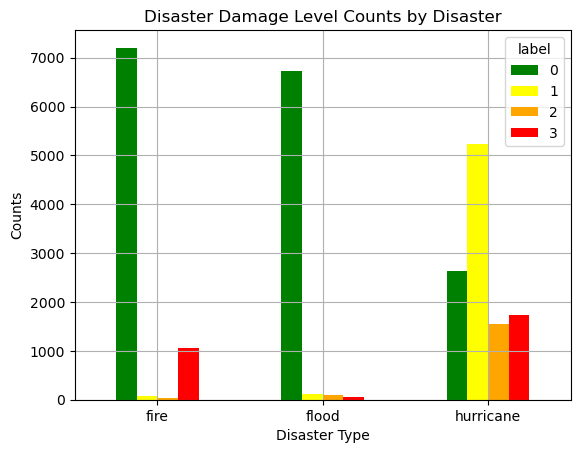

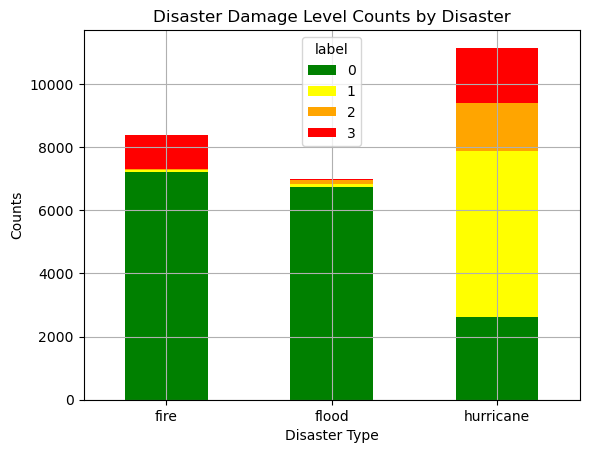

In [12]:
# Label count by disaster type

dd = df # in case we want a different sample
label_counts = dd.groupby('disaster_type')['label'].value_counts()
#total_counts = label_counts.groupby(level=0).sum()
#label_ratios = label_counts / total_counts

palette = ['red', 'blue', 'green', 'orange']
color_dict = {3: 'red', 0: 'green', 1: 'yellow', 2: 'orange'}

# Pivot the data for plotting
pivot_df = label_counts.unstack(fill_value=0)
display(pivot_df)
print(pivot_df)

# side-by-side
pivot_df.plot(kind='bar',  color=color_dict)
plt.xlabel('Disaster Type')
plt.ylabel('Counts')
plt.title('Disaster Damage Level Counts by Disaster')
#plt.legend(title='Damage Level Label',loc=(1.1,.5))
plt.grid()
plt.xticks(rotation=0)
plt.savefig(f'{figure_path}/eda_label_totals_sidebyside.png', dpi=96)
plt.show()

# slacked
pivot_df.plot(kind='bar', stacked=True, color=color_dict)
plt.xlabel('Disaster Type')
plt.ylabel('Counts')
plt.title('Disaster Damage Level Counts by Disaster')
#plt.legend(title='Damage Level Label')
plt.grid()
plt.xticks(rotation=0)
plt.savefig(f'{figure_path}/eda_label_totals.png', dpi=96)
plt.show()

**Observations**

We are dealing with a heavily imbalanced dataset.

**Label Ratios**

Since we have such heavily imbalanced dataset let's take a look at the relative ratios of labels.

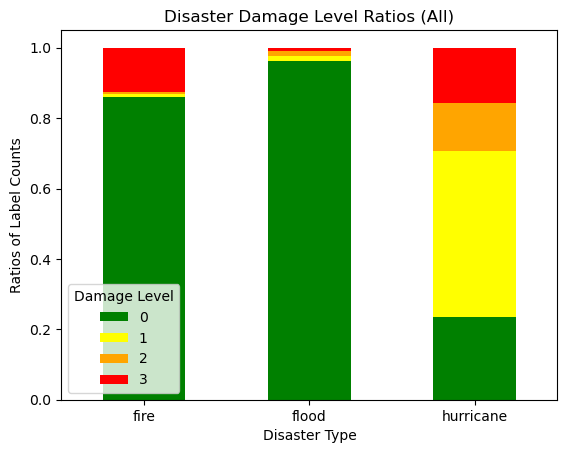

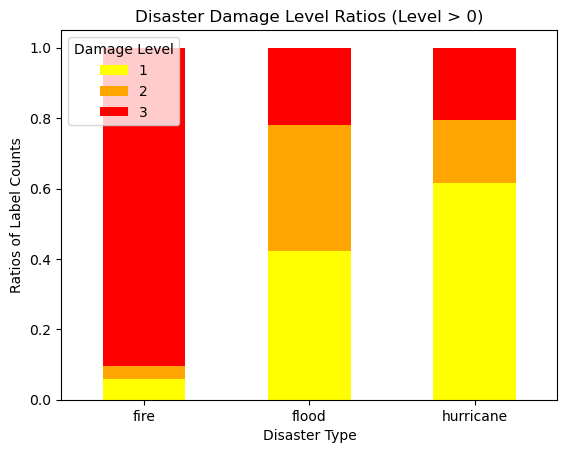

In [13]:
assert (df.shape[0] == 26535), 'Invalid dataframe length!'

dfs = [df, df[df.label > 0]]
for i, dd in enumerate(dfs):
    label_counts = dd.groupby('disaster_type')['label'].value_counts()
    total_counts = label_counts.groupby(level=0).sum()
    label_ratios = label_counts / total_counts

    palette = ['red', 'blue', 'green', 'orange']
    color_dict = {3: 'red', 0: 'green', 1: 'yellow', 2: 'orange'}
    
    # Pivot the data for plotting
    pivot_df = label_ratios.unstack(fill_value=0)
    #pivot_df = label_counts.unstack(fill_value=0)
    
    pivot_df.plot(kind='bar', stacked=True, color=color_dict)
    #display(pivot_df)
    plt.xlabel('Disaster Type')
    plt.ylabel('Ratios of Label Counts')
    plt.legend(title='Damage Level')
    plt.xticks(rotation=0)
    if i==0:
        plt.title('Disaster Damage Level Ratios (All)')
        plt.savefig(f'{figure_path}/eda_label_ratios.png', dpi=96)
    else:
        plt.title('Disaster Damage Level Ratios (Level > 0)')
        plt.savefig(f'{figure_path}/eda_label_ratios_excluded.png', dpi=96)

    plt.show()
assert (df.shape[0] == 26535), 'Invalid dataframe length!'

**Observations**

We can clearly we are dealing with a unbalanced dataset, the label distribution varies across disaster types.  This might be expected as fire damage might tend towards heavier damage, while flooding damage is limited to low lying thus tends to less damage, and finally where hurricane damage might be expected to be more varied due to combined factors such as flood and wind damage.

## Image Size Distribution

Let's explore the range of image sizes in our dataset

In [14]:
display(df.describe()[['height','width','image_size']].T[['min','max','mean']].apply(round))

,min,max,mean
height,3.0,716.0,79.0
width,3.0,890.0,80.0
image_size,84.0,410464.0,8170.0


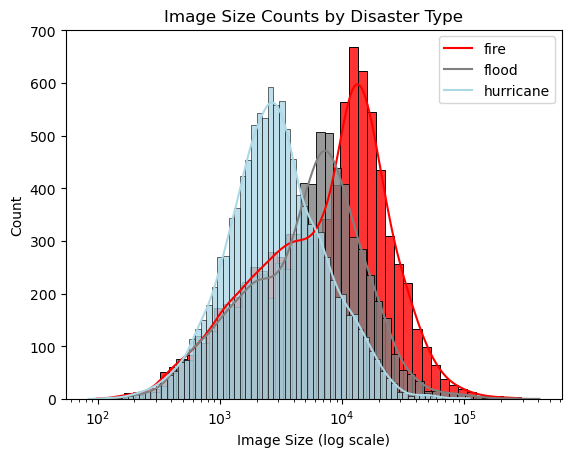

In [15]:
assert (df.shape[0] == 26535), 'Invalid dataframe length!'
alpha = 0.8
sns.histplot(data=df[df.disaster_type== 'fire'], x='image_size', kde=True, stat="count", label='image size', log_scale=True, color = 'red', alpha=alpha)
sns.histplot(data=df[df.disaster_type== 'flood'], x='image_size', kde=True, stat="count", label='image size', log_scale=True, color = 'grey', alpha=alpha)
sns.histplot(data=df[df.disaster_type== 'hurricane'], x='image_size', kde=True, stat="count", label='image size', log_scale=True, color = 'lightblue', alpha=alpha)
plt.legend(labels=['fire','flood','hurricane'])
plt.xlabel("Image Size (log scale)");
plt.title("Image Size Counts by Disaster Type");
plt.savefig(f'{figure_path}/eda_image_size_hist.png', dpi=96)

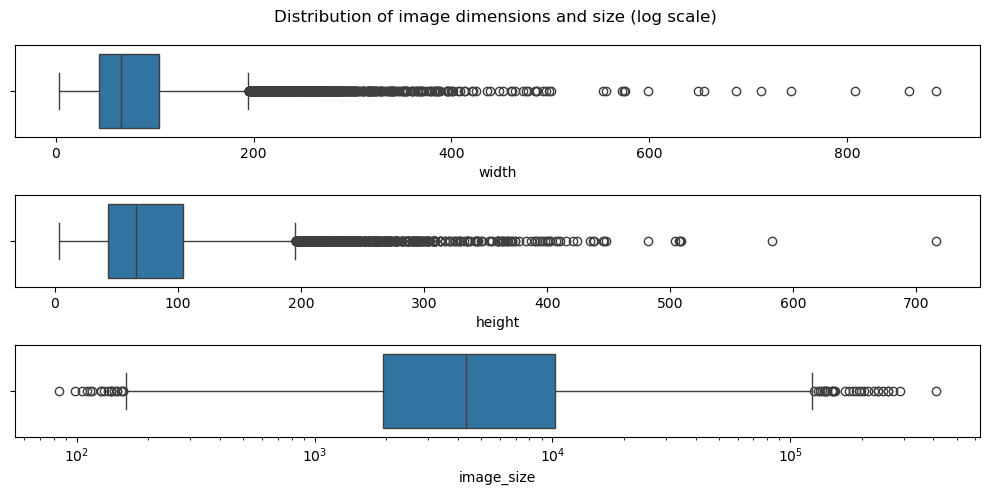

In [16]:
assert (df.shape[0] == 26535), 'Invalid dataframe length!'
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.boxplot(data=df, x="width", ax=ax[0], log_scale=False);
sns.boxplot(data=df, x="height", ax=ax[1], log_scale=False);
sns.boxplot(data=df, x="image_size", ax=ax[2], log_scale=True);

plt.suptitle('Distribution of image dimensions and size (log scale)')
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(f'{figure_path}/eda_image_size_box.png', dpi=96)

Image Size Damage Level

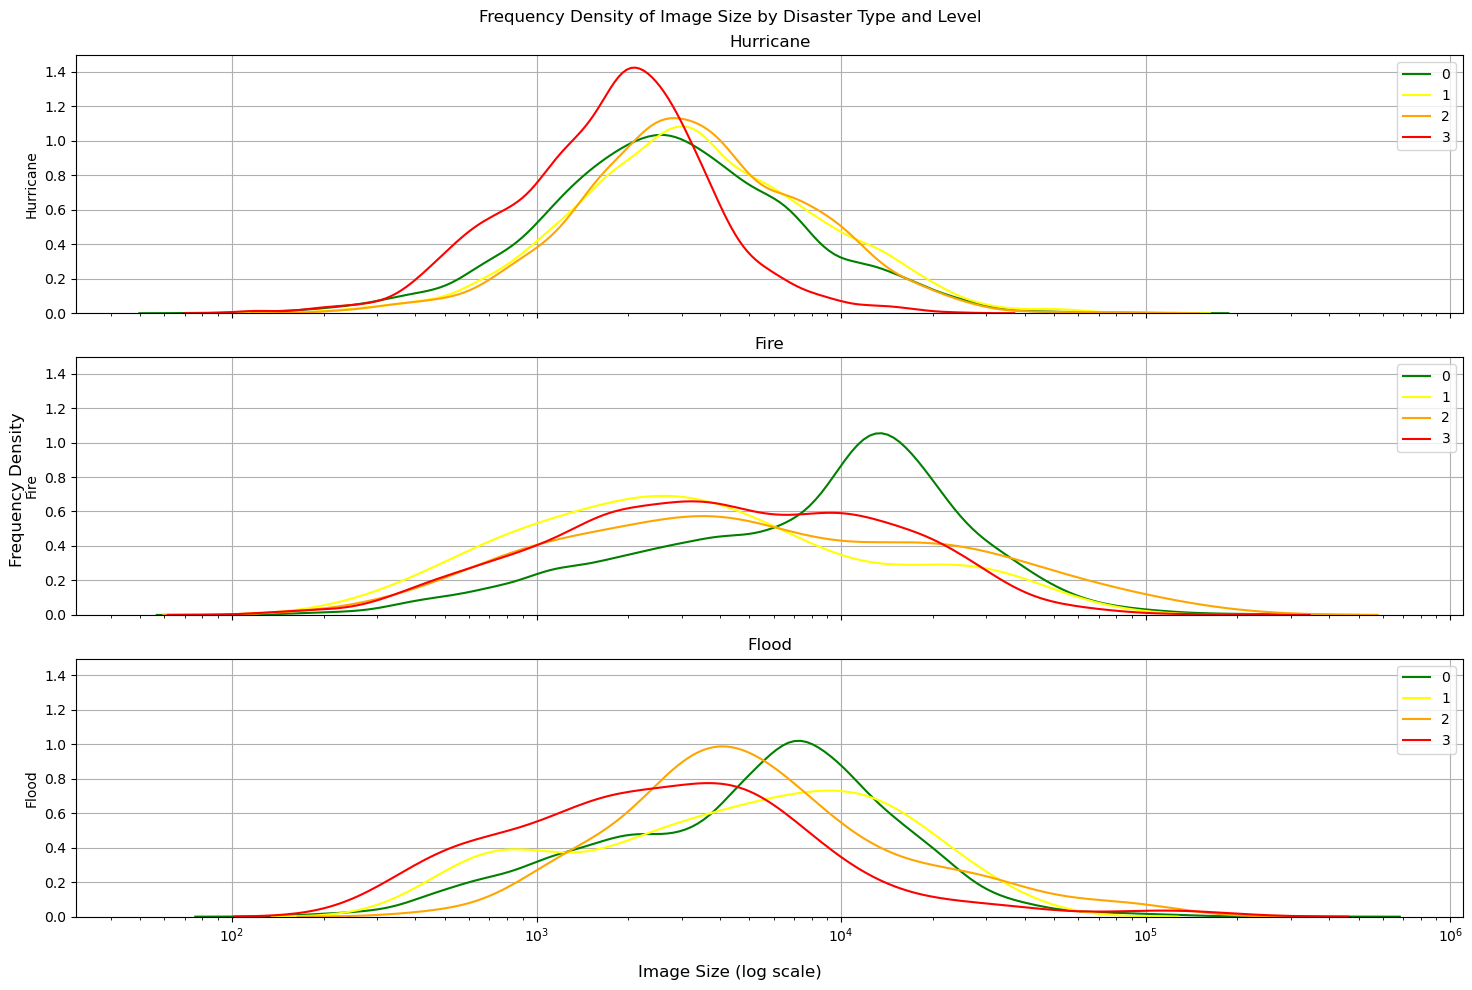

In [17]:
sns.set_palette("bright") # This only set the kde curve color...
color_dict = { 0: 'green', 1: 'yellow', 2: 'orange', 3: 'red'}

alpha = 1
#plt.figure(figsize=(15, 10))
share='all'
fig, ax = plt.subplots(3,1, sharex=share, sharey=share, figsize=(15,10))
for axi, type in enumerate(df.disaster_type.unique()):
    #plt.subplot(3, 1, axi+1, sharex='all', sharey='all')
    for level in range(4):
        #sns.histplot(data=df[(df.disaster_type== type) & (df.label== level)], x='image_size', kde=True, stat="count", label=f'{level}', log_scale=True, color = color_dict[level], alpha=alpha)
        sns.kdeplot(data=df[(df.disaster_type== type) & (df.label== level)], x='image_size', label=f'{level}', log_scale=True, color = color_dict[level], alpha=alpha, bw_adjust=.9, ax=ax[axi])
    ax[axi].legend()
    ax[axi].set_xlabel('');
    ax[axi].set_ylabel(f'{type.title()}')
    ax[axi].set_title(f'{type.title()}')
    ax[axi].grid()
    #plt.gca().set_yscale('log')

fig.supxlabel("Image Size (log scale)")
fig.supylabel('Frequency Density')
plt.suptitle("Frequency Density of Image Size by Disaster Type and Level")
plt.tight_layout()

plt.savefig(f'{figure_path}/eda_image_size_kde_bylevel.png', dpi=96)

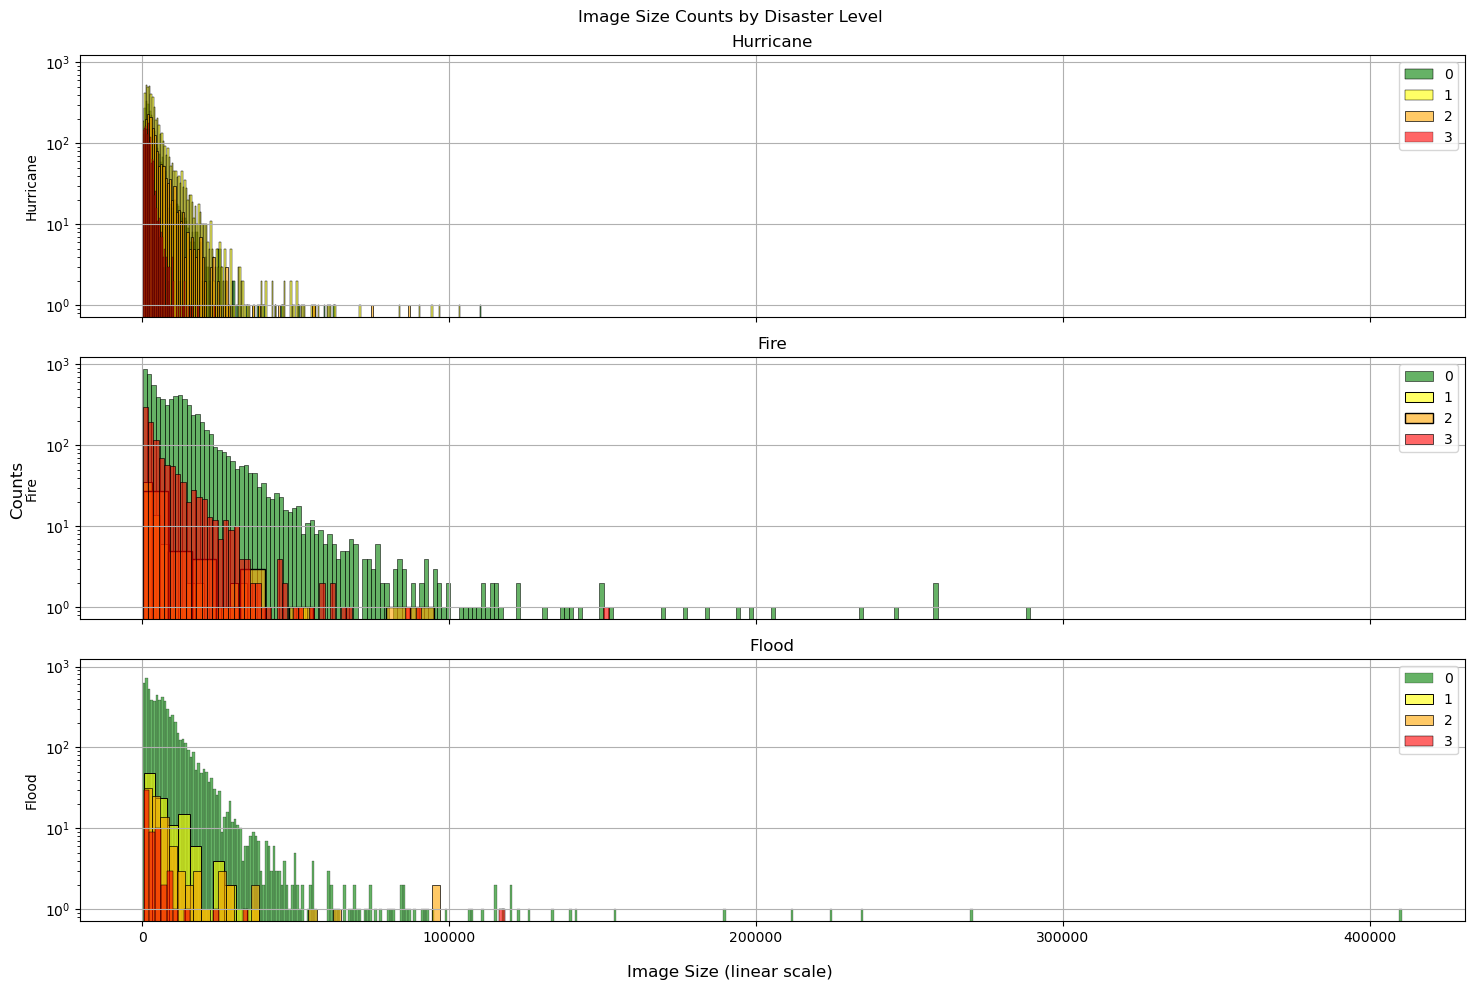

In [18]:

sns.set_palette("bright") # This only set the kde curve color...
color_dict = { 0: 'green', 1: 'yellow', 2: 'orange', 3: 'red'}

alpha = 0.6

share='all'
fig, ax = plt.subplots(3,1, sharex=share, sharey=share, figsize=(15,10))
for axi, type in enumerate(df.disaster_type.unique()):
    #plt.subplot(3, 1, axi+1, sharex='all', sharey='all')
    for level in range(4):
        subdf = df[(df.disaster_type== type) & (df.label== level)]
        sns.histplot(data=subdf, x=subdf['image_size'], kde=False, stat="count", label=f'{level}', log_scale=False, color = color_dict[level], alpha=alpha, ax=ax[axi])
    ax[axi].legend()
    ax[axi].set_xlabel('')
    ax[axi].set_ylabel(f'{type.title()}')
    ax[axi].set_title(f'{type.title()}')
    ax[axi].grid()
    plt.gca().set_yscale('log')
fig.supxlabel('Image Size (linear scale)')#,y=0)
fig.supylabel('Counts')#, x=0)
plt.suptitle("Image Size Counts by Disaster Level")
plt.tight_layout()

plt.savefig(f'{figure_path}/eda_image_size_hist_bylevel.png', dpi=96)

In [65]:
# Note there are very few images for type/level, flood/3.
30/(df[(df.disaster_type == 'flood')& (df.label == 3)].label.shape[0])

0.5084745762711864

In [57]:
%%time
# Now do color

# note: we might use replacement but we have compute and memory limits already, so smaller the better
sample_size = 30 # find a repesentive sample size %13,  
print(f'Using a sample size of: {sample_size}')


frames = []
for disaster_type in df.disaster_type.unique():
    for label in df.label.unique():
        #frames.append(df[(df.disaster_type == disaster_type) & (df.label == label)].sample(int(sample_size)))
        frames.append(df[(df.disaster_type == disaster_type) & (df.label == label)].sample(int(sample_size)))   
color_df = pd.concat(frames)
color_df.sample(4)

Using a sample size of: 30
CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 41.8 ms


,disaster,idx,label,height,width,image_size,img,disaster_type,avg_color
22563,midwest-flooding,3032,3,190,180,34200,"[[[212, 216, 211], [207, 212, 207], [209, 214,...",flood,"[93.63119883040936, 114.55061403508772, 119.78..."
17829,socal-fire,6678,3,20,23,460,"[[[80, 110, 115], [77, 106, 111], [79, 109, 11...",fire,"[85.65652173913044, 109.15869565217392, 106.15..."
21384,midwest-flooding,1853,0,214,129,27606,"[[[81, 105, 117], [79, 100, 113], [87, 108, 12...",flood,"[91.47239730493371, 108.12569731217852, 110.17..."
17467,socal-fire,6316,2,48,71,3408,"[[[31, 42, 34], [32, 43, 35], [34, 44, 36], [3...",fire,"[46.58274647887324, 59.403169014084504, 50.977..."


In [58]:
%%time
data = []
dd = color_df

for i in range(len(dd)):
    label = dd.iloc[i]['label']
    type_ = dd.iloc[i]['disaster_type']
    img = dd.iloc[i]['img']
    for color, color_name in zip(range(3), ['Red', 'Green', 'Blue']):
        pixels = img[:, :, color].ravel()
        data.extend([[label, type_, color_name, pixel] for pixel in pixels])

# Create a new DataFrame
plot_df = pd.DataFrame(data, columns=['Label', 'Type', 'Color', 'Intensity'])

CPU times: user 1min 55s, sys: 704 ms, total: 1min 56s
Wall time: 1min 56s


<Figure size 1000x600 with 0 Axes>

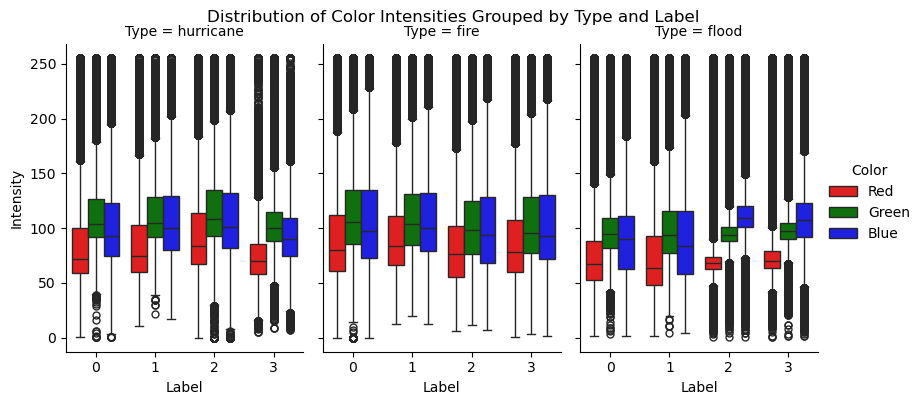

CPU times: user 25.3 s, sys: 4.1 s, total: 29.4 s
Wall time: 29.8 s


In [60]:
%%time
# Create a color palette that matches the color names
palette = {'Red': 'r', 'Green': 'g', 'Blue': 'b'}

fig = plt.figure(figsize=(10, 6))
#sns.boxplot(x='Label', y='Intensity', hue='Color', data=plot_df, palette=palette)
sns.catplot(x="Label", y="Intensity", hue="Color", col="Type", data=plot_df, kind="box", height=4, aspect=.7, palette=palette)

plt.suptitle('Distribution of Color Intensities Grouped by Type and Label',y=1)

plt.savefig(f'{figure_path}/eda_image_color_by_level.png', dpi=96)
plt.show()

Image Size Damage Level

**Observations**

We can see that there is a wide range of image dimensions and sizes.  From the paper describing the dataset we might expect that larger images show a larger area and that smaller images are a polygon representing a building.  We can also see that the distribution of image sizes varies depending on the disaster type.  We might consider how we might normalize the images sizes, for example we might crop larger images or center smaller images on background(average pixel color or black).  We might also rotate and crop images to address label imbalance.

## Visual Analysis

In addition to statistical analysis, we shall visualize a few samples to gave a general understanding of our data set.  We've created a library to ease this task.

In [ ]:
# Let's create some functions to aid our exploration of images
assert (df.shape[0] == 26535), 'Invalid dataframe length!'

import eda_utils
from importlib import reload 
reload(eda_utils) 
from eda_utils import show_df

show_df(df, seed=1001, share=False, title='Image Sample (from complete dataset)')

**Observation**

We can see that we are dealing with a wide range of image sizes and aspect ranges.  Also, we can see from this simple sample that distribution of label is now equal.  This is precisely what we expect our analysis of size and label distribution.

In [ ]:
# Recall image size distribution
display(df[['image_size','width','height']].describe().T)

Here we are filtering low aspect ratio image to make visul comparison between disaster types and levels easier.  
This also allows use to use shared x and y scales in our subplots.  This is gain a general understanding of the dataset.

In [ ]:
lower = 104 * 2
upper = np.inf
show_df(df[(df['width']>lower) & (df['width']<upper) &
        (df['height']>lower) & (df['height']<upper)], seed=5707, share=False)

In [ ]:
def show_sample(dd, seed=None, share=False, title=None):
    random_state = seed
    
    disaster_types = ['fire','flood','hurricane']
    rows, cols = len(disaster_types),4
    fig, ax = plt.subplots(rows,cols, sharex=share, sharey=share, figsize=(10,3*rows))
    fig.suptitle(title)

    for i in range(rows):  # type index
        for j in range(cols): # label index
            axk = ax[i][j]
            #axk.plot(1,1,marker='o') # debug
            dd = df[(df['disaster_type']== disaster_types[i]) & (df['label']== j)].sample(1)
            img = dd.iloc[0].img
            axk.imshow(img.astype(np.uint8))
            if i == 2:
                axk.set_xlabel(f'{j}')
            if j == 0:
                axk.set_ylabel(f'{disaster_types[i]}')
    #plt.subplots_adjust(wspace=0.2,hspace=0.2)
    #plt.tight_layout()
    fig.align_xlabels()
    fig.align_ylabels()
    fig.supxlabel('Damage Level')#,y=0)
    fig.supylabel('Damage Type')#, x=0)
       
show_sample(df,seed = 1, title='Image Samples of each Disaster Type and Damage Level')
plt.savefig(f'{figure_path}/eda_image_sample_each_type_label.png', dpi=96)

In [ ]:
# filter by (filtered around median aspect ratio)
upper = 104
lower = 43
subframe = df[
        (df['width']>lower) & (df['width']<upper) &
        (df['height']>lower) & (df['height']<upper)]

show_sample(subframe,seed = 11, title='Image Samples of each Disaster Type and Damage Level (filtered around median aspect ratio)')
#plt.savefig(f'{figure_path}/eda_image_sample_each_type_label_common_aspect.png', dpi=96)

**Observations**
A comparative visual analysis was performed using the entire dataset sampled for each disaster type and damage level. 

The dataset appers to contain cropped smaller images detailing areas from a set of larger area images.
There are some black pixel artifacts in the larger image that also appear in the cropped images.

It can be seen that some of the cropped images show the same area shifted.
Some images are cropped with a high aspect ratio to detail a specific structure.
All images appear to be of a same scale and resolution, however there appears to be some blurring, possibly due to geometry transform.

There are shadows in present in all disaster types and levels however the satelite images were taken at or near local noon.
The fire and flood images show some occultation due to smoke and clouds.


In [ ]:
# Show a sample of images
#show_df(df, seed = None)

# Show Color Distribution
#eda_utils.plot_color_distribution(img)
#eda_utils.get_color_density(df.sample(1))
#eda_utils.show_color_density(df)

# Appendix i. Image Analysis

Some examples for image visualization and analysis where provided.  We'll retained these as a reference. 

## Visualize an image and its label in the dataset.

In [ ]:
assert (df.shape[0] == 26535), 'Invalid dataframe length!'
disaster = disaster_list[0]
images = data[disaster]["images"]
labels = data[disaster]["labels"]

# index of the image to display
idx = 0
img = images[idx]
label = labels[idx]

plt.title(f"{disaster}, image {idx}, label {label}")
plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

# show shape of image
print(f"image shape: {img.shape}")
assert (df.shape[0] == 26535), 'Invalid dataframe length!'

## Extracting Color Information.
Each image is an RGB image represented as a numpy array of dimensions ~~(width, height, 3)~~ (ncols, nrows, 3) which represent (image_height, image_width, colors). The last dimension corresponds to the RGB *color channels* in the image. We can split the image by color channels and visualize each of them individually.

In [ ]:
assert (df.shape[0] == 26535), 'Invalid dataframe length!'
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img[:, :, 0], cmap="Reds", vmin=0, vmax=255)
plt.title("Red Channel")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img[:, :, 1], cmap="Greens", vmin=0, vmax=255)
plt.title("Green Channel")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img[:, :, 2], cmap="Blues", vmin=0, vmax=255)
plt.title("Blue Channel")
plt.axis("off")

plt.show()
assert (df.shape[0] == 26535), 'Invalid dataframe length!'

We can zoom in on just a pixel as well.

In [ ]:
assert (df.shape[0] == 26535), 'Invalid dataframe length!'
coord = (15, 35)
pixel_value = img[coord[0], coord[1], :]
pixel_image = np.array([[pixel_value]])

plt.imshow(pixel_image)
plt.axis("off")
plt.show()

print(f"Pixel value: {pixel_value}, coordinate: {coord}")
assert (df.shape[0] == 26535), 'Invalid dataframe length!'

## Extracting Edge and Texture Information

So far we have considered the **color** information in an image. However, other important aspects of an image are the edges and texture.

Let us consider some popular feature processing methods for extracting edge and texture information. We will use the utilities provided in `feature_utils.py`.

In [ ]:
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern

Let's try the Sobel Edge Filter.

Read more about Sobel edge detection: https://en.wikipedia.org/wiki/Sobel_operator and https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html

In [ ]:
edges = get_sobel_features(img)
plt.imshow(edges, cmap="gray")
plt.title("Sobel Edge Detection")
plt.axis("off")
plt.show()

Now let's look at local binary patterns.

Read more about LBP: https://en.wikipedia.org/wiki/Local_binary_patterns and https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

In [ ]:
lbp = get_local_binary_pattern(img, radius=3)
plt.imshow(lbp, cmap="gray")
plt.axis("off")
plt.title("Local Binary Pattern (LBP)")
plt.show()

Another popular filter for image processing is the Gabor filter. The Gabor filters are a family of filters parametrized by orientation, frequency, bandwith, etc. Let's generate one such filter.

Read more about Gabor filters: https://en.wikipedia.org/wiki/Gabor_filter and https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html

In [ ]:
theta = 0
sigma = 1.0
frequency = 0.1

kernel = generate_gabor_kernel(theta, sigma, frequency)
gabor = get_gabor_features(img, kernel)

Let's visualize this filter (aka kernel) and the response of the image when we apply the filter. Concretely we are taking the convolution of the image with the filter. See https://en.wikipedia.org/wiki/Kernel_(image_processing) for more details.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot Gabor Kernel
axs[0].imshow(kernel, cmap="gray")
axs[0].axis("off")  # Remove axis
axs[0].set_title("Gabor Kernel")

# Plot Gabor Kernel Response
axs[1].imshow(gabor, cmap="gray")
axs[1].axis("off")  # Remove axis
axs[1].set_title("Gabor Kernel Response")

plt.show()

# Appendix 0. Resources

Grad project overview: <https://ds100.org/sp24/gradproject/>

Paper on dataset: <https://arxiv.org/pdf/1911.09296.pdf>

Complete dataset: <https://xview2.org/>

Dealing with Imbalanced Classification: https://www.mdpi.com/2078-2489/14/1/54/pdf?version=1673866802


# Appendix 1. Project Overview

<h3 id="topic-1-computer-vision">Topic 1: Computer Vision</h3> <p>In disaster situations, it is important for emergency response efforts to have access to quick and accurate information about an area in order to respond effectively. This project will explore how data science techniques can be useful for such efforts.</p> <h4 class="no_toc" id="project-goals">Project Goals</h4> <ul> <li>Learn to work with image data by learning to use common feature extraction techniques like Sobel edge filtering.</li> <li>Learn to work on real-world data with common complexities such as class imbalance, low signal-to-noise ratio, and high dimensional data.</li> <li>Learn how to design effective preprocessing and featurization pipelines for solving difficult machine learning tasks.</li> </ul> <h4 class="no_toc" id="mission">Mission</h4> <p>You have been hired by a crisis response agency to help assist them with your impressive data science skills! The agency has found that using satellite imagery is highly useful for supplying information for their response efforts. Unfortunately, however, annotating these high-resolution images can be a slow process for analysts. Your mission is to help address this challenge by developing an automatic computer vision approach!</p> <h4 class="no_toc" id="dataset-description">Dataset Description</h4> <p>The agency would like you to develop your approach on their internal dataset, derived from the <a href="https://xview2.org/" target="_blank">xView2 Challenge Dataset</a>. This dataset contains satellite images of buildings after various natural disasters. The buildings are labeled based on the level of damage sustained on a scale ranging from 0 (no damage) to 3 (destroyed).</p> <p>You can access all of the data within the <code class="language-plaintext highlighter-rouge">./satellite-image-data</code> directory. The dataset consists of the following folders for different natural disasters</p> <ol> <li><code class="language-plaintext highlighter-rouge">midwest-flooding</code></li> <li><code class="language-plaintext highlighter-rouge">socal-fire</code></li> <li><code class="language-plaintext highlighter-rouge">hurricane-matthew</code></li> </ol> <p>Within each folder is a zip file <code class="language-plaintext highlighter-rouge">train_images.npz</code> containing the satellite images as numpy arrays and a <code class="language-plaintext highlighter-rouge">train_labels.npy</code> file with corresponding damage level labels.</p> <blockquote> <p>Testing: In the main directory, there are also the <code class="language-plaintext highlighter-rouge">test_images_hurricane-matthew.npz</code> and <code class="language-plaintext highlighter-rouge">test_images_flooding-fire.npz</code> zip files. The first contains test images from the <code class="language-plaintext highlighter-rouge">hurricane-matthew</code> disaster and the latter consists of a combination of test images from <code class="language-plaintext highlighter-rouge">midwest-flooding</code> and <code class="language-plaintext highlighter-rouge">socal-fire</code>.</p> </blockquote> <h4 class="no_toc" id="getting-started">Getting Started</h4> <p>To help you with onboarding, the agency has provided a starter notebook <a href="https://data100.datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FDS-100%2Fsp24-student&amp;urlpath=lab%2Ftree%2Fsp24-student%2Fgrad-proj%2Fcv-satellite-images%2Fstarter.ipynb&amp;branch=main" target="_blank"><code class="language-plaintext highlighter-rouge">starter.ipynb</code></a> which will introduce you to the dataset and some useful internal tools. After completing the onboarding assignment you will be comfortable with the following:</p> <ol> <li>Loading and visualizing data using tools from <code class="language-plaintext highlighter-rouge">data_utils.py</code></li> <li>Processing different color channels in the dataset images.</li> <li>Extracting feature information from images using tools from <code class="language-plaintext highlighter-rouge">feature_utils.py</code>.</li> </ol> <h4 class="no_toc" id="exploratory-data-analysis">Exploratory Data Analysis</h4> <p>Now that you have successfully been onboarded, the agency would like you to start performing some exploratory data analysis to build an initial understanding of the data. As part of the exploratory data analysis, the agency is interested in understanding certain aspects of the dataset better. Specifically, they are looking for:</p> <ul> <li>Basic statistics about the dataset, such as the number of images per disaster type and the distribution of image sizes and damage labels.</li> <li>Insights into useful image features for classifying images based on disaster type or damage level. Previous interns have found color information to be potentially useful. You are tasked with verifying this and exploring whether color features can effectively differentiate: <ul> <li><code class="language-plaintext highlighter-rouge">midwest-flooding</code> from <code class="language-plaintext highlighter-rouge">socal-fire</code> images.</li> <li>Damage levels 1 and 3 within the <code class="language-plaintext highlighter-rouge">hurricane-matthew</code> dataset.</li> </ul> </li> </ul> <p>Please prepare an EDA report to present to the agency leadership with the above in mind.</p> <h4 class="no_toc" id="project-tasks">Project Tasks</h4> <p>Now that leadership is pleased with your initial EDA report and confident in your data science ability, they would like you to assist the agency with various tasks. <em>Please complete Task A first and then Task B.</em></p> <h4 class="no_toc" id="task-a-disaster-type-classification"><em>Task A: Disaster Type Classification</em></h4> <p>The agency consists of different subdivisions for assisting with different disaster types, e.g., fires, floods, etc. In the event of a disaster, the agency mounts its response effort by first assessing the type of disaster and then requesting the appropriate subdivision to assist with the disaster.</p> <p>Your task is to assist the agency with making this initial call quickly by automatically classifying images based on the disaster scenario. Specifically, your role will be to build a classifier that can distinguish images from the <code class="language-plaintext highlighter-rouge">midwest-flooding</code> disaster and the <code class="language-plaintext highlighter-rouge">socal-fire</code> disaster.</p> <p>To assess your performance, please submit predictions for the <code class="language-plaintext highlighter-rouge">test_images_flooding-fire.npz</code> images. This should be in a csv file <code class="language-plaintext highlighter-rouge">test_images_flooding-fire_predictions.csv</code> consisting of a single column with no header, with a 0 to indicate a <code class="language-plaintext highlighter-rouge">midwest-flooding</code> prediction and a 1 to indicate a <code class="language-plaintext highlighter-rouge">socal-fire</code> prediction. The prediction in row <em>i</em> should correspond to the <em>ith</em> image.</p> <h4 class="no_toc" id="task-b-damage-level-classification"><em>Task B: Damage Level Classification</em></h4> <p>The agency needs to know how severe a disaster is in order to allocate resources for a response effectively. The agency is especially concerned with human lives and uses building damage as an important metric for disaster severity.</p> <p>Your task is to assist the agency by automatically detecting the building damage level after a disaster. Specifically, create a damage level classifier for the <code class="language-plaintext highlighter-rouge">hurricane-matthew</code> disaster.</p> <p>To assess your performance, please submit predictions for the <code class="language-plaintext highlighter-rouge">test_images_hurricane-matthew.npz</code> images. This should be in a CSV file <code class="language-plaintext highlighter-rouge">test_images_hurricane-matthew_predictions.csv</code> consisting of a single column with no header, with a 0-3 prediction of the damage level. The prediction in row <em>i</em> should correspond to the <em>i</em>th image.</p> <h4 class="no_toc" id="resources">Resources</h4> <p>To assist you in your efforts the agency has compiled the following list of resources:</p> <ul> <li>For more background about the dataset you can look at the <a href="https://arxiv.org/pdf/1911.09296.pdf" target="_blank">paper</a> associated with the dataset.</li> <li>For image processing, <a href="https://scikit-image.org/" target="_blank">scikit-image</a> is a very useful library. This <a href="https://www.kaggle.com/code/bextuychiev/full-tutorial-on-image-processing-in-skimage" target="_blank">tutorial</a> may be helpful for learning how to use the library.</li> <li>For problems with imbalanced classes, the <a href="https://imbalanced-learn.org/stable/index.html" target="_blank">imblearn</a> library has useful tools and examples.</li> </ul>

# Appendix 2. Deliverables

<h2 id="group-formation--research-proposal">Checkpoint 0. Group Formation + Research Proposal (complete)</h2> 
<p>The first deliverable of your group project is just to form your group, choose a dataset, and submit your implementation plan to <a href="https://forms.gle/DcBp3ZbM8TpTfSRD6" target="_blank">this google form</a> by 11:59 pm on 3/15. The implementation plan should consist of a series of steps for completing the project along with a timeline. You may form groups of 2 or 3 people with any Data 200/200A/200S student.</p> <!-- ## Checkpoint 1: EDA + Internal Peer Review The checkpoint is intended to keep you on track to meet your project goals. You will need to submit exploratory data analysis results on Gradescope. This will include submitting both a report of your results so far as well as all code necessary to replicate your results. Your submission should include: - **Project Introduction and Goals:** Please briefly introduce your project. Think about introducing your project to someone who has a background in data science but does not know the dataset and your research question. This part should not exceed 500 words. Here are some components to help you get started: - What is the dataset about? How was the data collected? What are the available features and information? What is the size of the dataset? - What questions do you plan to ask about the dataset? Why do we care about such a problem? - What is your workflow for the project? Your first step, second step… - What are the models you plan to use? Why would the model be a good fit for your project? What are potential pitfalls you could run into? - What is your goal for the project? What are the expected deliverables? - **EDA:** Show the results from your EDA work. You should include: - **Data Sampling and Collection** - How was the data collected? - Was there any potential bias introduced in the sampling process? - **Data Cleaning** - What type of data are you currently exploring? - What is the granularity of the data? - What does the distribution of the data look like? Are there any outliers? Are there any missing or invalid entries? - **Exploratory Data Analysis** - Is there any correlation between the variables you are interested in exploring? - How would you cleanly and accurately visualize the relationship among variables? - What are your EDA questions? (For example, are there any relationships between A and B? What is the distribution of A?). - Do you need to perform data transformations? - **Figures(tables, plots, etc.)** - Descriptions of your figures. Takeaways from the figures. - These figures must be of good quality (i.e. they must include axes, titles, labels, etc) and they must be relevant to your proposed analysis. - **Other Preliminary Results (optional)**: Please optionally post any other preliminary results here for our information. ## Checkpoint 2: Mandatory Check-In The purpose of this checkpoint is to ensure you are making progress and on schedule to submit the first draft of the project in 2 weeks time. You will be required to make a one-page document summarizing all of your progress so far, and you will have to bring the document to a one-on-one meeting with a staff member. Please look at the <a href="#checkpoint-2-mandatory-check-in-75">rubric</a> for the checkpoint and what you need to include in the <a href="#final-project-report">Final Project Report</a> when determining what to include in your one-page document; the document should be a brief summary of all your progress so far. The staff member will quickly skim the document and give you guidance on the project as a whole. More details about submitting the one-page document and signing up for the staff member meeting will be announced on Ed soon. <!-- ## Final Project Report The project submission should include the following two components, as well as the YouTube video recording (more information to be announced later). --> <!-- ### [Component 1] Analysis Notebooks This component includes all the Jupyter Notebook(s) containing all the analyses that you performed on the datasets to support your claims in your write-up. Make sure that all references to datasets are done as `data/[path to data files]`. By running these notebooks, we should be able to replicate all the analysis/figures done in your write-up. Your analysis notebook(s) should address all of the following components in the data science lifecycle. Please note that a thorough explanation of your thought process and approach is **as important as** your work. Unreadable/uncommented code will lose points. Along with the code for the EDA portion (which also has to be included), we have provided a few additional preliminary questions/tips you can consider for the modeling portion of the project: - What are the research questions that you are answering through your analysis? What type of machine learning problem are you investigating? - Which model(s) do you use and why? - How do you use your data for training and testing? - Does your model require hyperparameter tuning? If so, how do you approach it? - How do you engineer the features for your model? What are the rationales behind selecting these features? - How do you perform cross-validation on your model? - What loss metrics are you using to evaluate your model? Why? - From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting? - How would you improve your model based on the outcome? - Are there any further extensions to your model that would be worth exploring? ### [Component 2] Project Write-Up This is a single PDF that summarizes your workflow and what you have learned. It should be structured as a research paper and include a title, list of authors, abstract, introduction, description of data, methodology, summary of results, discussion, conclusion, and references. Make sure to number figures and tables, include informative captions, and ensure you include the provenance of the figures in the main narrative. We encourage you to render the PDF using LaTeX, but we will not be able to provide assistance with LaTeX-related issues. Specifically, you should ensure you address the following in the narrative: * Clearly state the research questions and why they are interesting and important. * Introduction: ensure you include a brief survey of related work on the topic(s) of your analysis. Be sure to reference current approaches/research in the context of your project, as well as how your project differs from or complements existing research. You must cite all the references you discuss in this section. * Description of data: ensure you outline the summary of the data and how the data was prepared for the modeling phase (summarizing your EDA work). If applicable, descriptions of additional datasets that you gathered to support your analysis may also be included. * Methodology: carefully describe the methods/models you use and why they are appropriate for answering your research questions. You must include a detailed description of how modeling is done in your project, including inference or prediction methods used, feature engineering and regularization if applicable, and cross-validation or test data as appropriate for model selection and evaluation. You may also include interesting findings involving your datasets. * Summary of results: analyze your findings in relation to your research question(s). Include/reference visualizations and specific results. Discuss any interesting findings from your analysis. You are encouraged to compare the results using different inference or prediction methods (e.g. linear regression, logistic regression, or classification and regression trees). Can you explain why some methods performed better than others? * Discussion: evaluate your approach and discuss any limitations of the methods you used. Also, briefly describe any surprising discoveries and whether there are any interesting extensions to your analysis. The narrative PDF should include figures sparingly to support specific claims. It can include a few runnable code components, but it should not have large amounts of code. The length of the report should be 8 ± 2 pages when it is printed as a PDF, excluding figures and code. Tip: if you need to write a large amount of LaTeX on markdown, you may want to use the `%%latex` cell magic. However, we also encourage you to explore [Overleaf](https://www.overleaf.com) for easily writing clean LaTeX documents. Please submit everything as a zip file to the final report submission portal on Gradescope. Please make sure the folder in the zip file has the following structure: ``` [your studentIDs joined by _]/ data/[all datasets used] analysis/[analysis notebooks] narrative/[narrative PDF] figures/[figures included in the narrative PDF] ``` Please use student IDs joined by `_` as the name for the top-level directory. The analysis notebooks must be runnable within this directory structure. If the narrative PDF includes any figures that are created in the analysis notebooks, the figures should be saved to `figures/` by the analysis notebooks. --> <h2 id="rubrics">Rubrics</h2> <p>This section includes a rubric for how different project deliverables are going to be graded. This section will be updated as we get further along the project timeline.</p> <h3 id="group-formation--research-proposal-5">Group formation + Research Proposal (5%)</h3> <ul> <li>Short paragraph description of implementation plan and timeline (2%).</li> <li>Forming teams by the deadline (3%).</li>

---

<h2 id="checkpoint-1-eda--internal-peer-review">Checkpoint 1: EDA + Internal Peer Review (in process)</h2> <p>The checkpoint is intended to keep you on track to meet your project goals. You will need to submit an exploratory data analysis report to Gradescope. This will include submitting both a report of your results so far as well as all code necessary to replicate your results. Please answer all the questions below. Your submission should include:</p> <!-- - **Project Introduction and Goals:** Please briefly introduce your project. Think about introducing your project to someone who has a background in data science but does not know the dataset and your research question. This part should not exceed 500 words. Here are some components to help you get started: - What is the dataset about? How was the data collected? What are the available features and information? What is the size of the dataset? - What questions do you plan to ask about the dataset? Why do we care about such a problem? - What is your workflow for the project? Your first step, second step… - What are the models you plan to use? Why would the model be a good fit for your project? What are potential pitfalls you could run into? - What is your goal for the project? What are the expected deliverables? --> <ul> <li><strong>Data Sampling and Collection</strong> <ul> <li>How was the data read and sampled for your EDA process?</li> <li>Was there any potential bias introduced in the sampling process?</li> </ul> </li> <li><strong>Data Cleaning</strong> <ul> <li>What type of data are you currently exploring?</li> <li>What is the granularity of the data?</li> <li>What does the distribution of the data look like? Are there any outliers? Are there any missing or invalid entries?</li> <li>The data is not structured. How did you turn it into a structured format? What features have you engineered?</li> </ul> </li> <li><strong>Exploratory Data Analysis</strong> <ul> <li>Is there any correlation between the variables you are interested in exploring?</li> <li>How would you cleanly and accurately visualize the relationship among variables?</li> <li>What are your EDA questions? (For example, are there any relationships between A and B? What is the distribution of A?).</li> <li>Do you need to perform data transformations?</li> </ul> </li> <li><strong>Figures(tables, plots, etc.)</strong> <ul> <li>Descriptions of your figures. Takeaways from the figures.</li> <li>These figures must be of good quality (i.e. they must include axes, titles, labels, etc.) and they must be relevant to your proposed analysis.</li> </ul> </li> </ul> <p>Concretely, here are the minimal requirements for EDA for each project. Using your knowledge from Data 200, what would be appropriate data visualizations? You are welcome to do more than the minimal requirements.</p> <ul> <li><strong>Computer Vision</strong>: <ul> <li>Number of images per disaster.</li> <li>Image sizes in each dataset. Should ideally observe large variance in sizes, but similar distribution for each disaster.</li> <li>Damage labels. Should observe imbalances in the labels.</li> <li>(Open-ended) Visualize the distribution of color for different disasters.</li> <li>(Open-ended) Convey that the distributions are “separable” somehow.</li>

Notes

<h2 id="rubrics">Rubrics</h2> <p>This section includes a rubric for how different project deliverables are going to be graded. This section will be updated as we get further along the project timeline.</p> <h3 id="group-formation--research-proposal-5">Group formation + Research Proposal (5%)</h3> <ul> <li>Short paragraph description of implementation plan and timeline (2%).</li> <li>Forming teams by the deadline (3%).</li> </ul> <h3 id="checkpoint-1-eda--internal-peer-review-10">Checkpoint 1: EDA + Internal Peer Review (10%)</h3> <ul> <li>Data Sampling and Collection (0.5%).</li> <li>Data Cleaning (3%).</li> <li>Exploratory Data Analysis (3%).</li> <li>Figures (tables, plots, etc.) (3%).</li> <li>Internal Peer Review (0.5%).</li>